In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image as pil_image
import os
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
img = pil_image.open('train_img/81304/000031772.jpg')
img=img.resize((512,512))
img = np.array(img)
img=img/255
img.shape

(512, 512, 3)

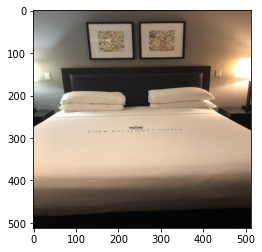

In [3]:
plt.imshow(img)


# Mask

In [4]:
img_m = pil_image.open('train_masks/00006.png')
new_image = pil_image.new("RGBA", img_m.size, "WHITE") # Create a white rgba background
new_image.paste(img_m, (0, 0), img_m)    
img_m = new_image.convert('RGB')
img_m = img_m.resize((512,512))
imgm = np.array(img_m)
mask_img = imgm/255
mask_img.shape

(512, 512, 3)

In [5]:
mask_img[:,:,1] = np.where(mask_img[:,:,1]>0,1,0)
mask_img[:,:,2] = np.where(mask_img[:,:,2]>0,1,0)

In [6]:
mask_img.shape

(512, 512, 3)

In [7]:
mask_img[np.logical_and((mask_img[:,:,0]==1),(mask_img[:,:,1]==0),(mask_img[:,:,2]==0))]=(0,0,0)

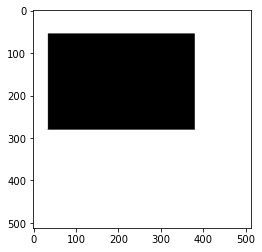

In [8]:
plt.imshow(mask_img)


In [9]:
np.unique(mask_img[:,:,0],return_counts=True)

(array([0., 1.]), array([ 77972, 184172]))

# Combine img +mask

In [10]:
masked_img = deepcopy(img)
#masked_img[np.logical_and((mask_img[:,:,0]==0),(mask_img[:,:,1]==0),(mask_img[:,:,2]==0))] = (1,1,1)
masked_img[mask_img==0] = 1

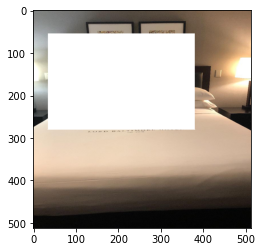

In [11]:
plt.imshow(masked_img)

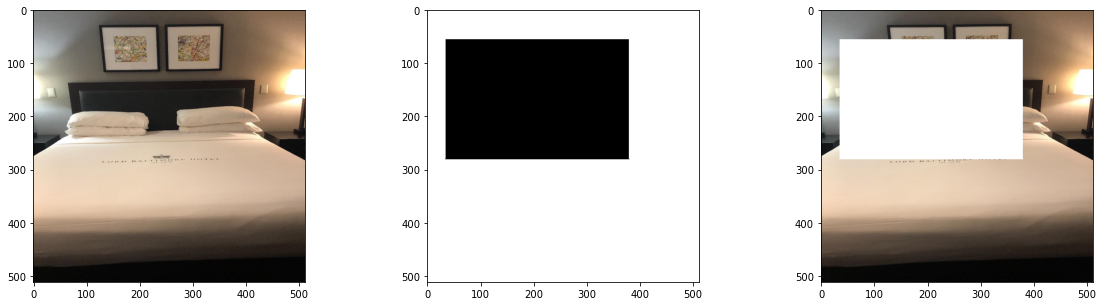

In [12]:
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask_img)
axes[2].imshow(masked_img)
plt.show()

# Model 

In [13]:
from tensorflow.keras.layers import Input, Dense, ZeroPadding2D
from tensorflow.keras.models import Model
from libs.pconv_layer import PConv2D
#from libs.gconv_layer import GConv2D 

In [17]:
from libs.pconv_layer import PConv2D

In [14]:
shape=(512,512,3)
input_img = Input(shape=(shape[0], shape[1], shape[2],))
input_mask = Input(shape=(shape[0], shape[1], shape[2],))
output_img1, output_mask1 = PConv2D(8, kernel_size=(7,7), strides=(2,2))([input_img, input_mask])
output_img2, output_mask2 = PConv2D(16, kernel_size=(5,5), strides=(2,2))([output_img1, output_mask1])
output_img3, output_mask3 = PConv2D(32, kernel_size=(5,5), strides=(2,2))([output_img2, output_mask2])
output_img4, output_mask4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img3, output_mask3])
output_img5, output_mask5 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img4, output_mask4])
output_img6, output_mask6 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img5, output_mask5])
output_img7, output_mask7 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img6, output_mask6])
output_img, output_mask8 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img7, output_mask7])

# Create model
model = Model(
    inputs=[input_img, input_mask], 
    outputs=[
        output_img1,output_img2,output_img3,output_img4,output_img5,output_img6,output_img7,output_img, output_mask1, output_mask2, 
        output_mask3, output_mask4, output_mask5,
        output_mask6, output_mask7, output_mask8
    ])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary of the model
model.summary()

2022-05-23 17:59:21.701656: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-23 17:59:21.703336: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
p_conv2d (PConv2D)              [(None, 256, 256, 8) 1184        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 128, 128, 16 3216        p_conv2d[0][0]               

In [15]:
formatted_img = np.expand_dims(masked_img, 0)
formatted_mask = np.expand_dims(mask_img, 0)
print(f"Original Mask Shape: {formatted_mask.shape} - Max value in mask: {np.max(formatted_mask)}")

o_img1,o_img2,o_img3,o_img4,o_img5,o_img6,o_img7,o_img,o1, o2, o3, o4, o5, o6, o7, o8 = model.predict([formatted_img, formatted_mask])

Original Mask Shape: (1, 512, 512, 3) - Max value in mask: 1.0


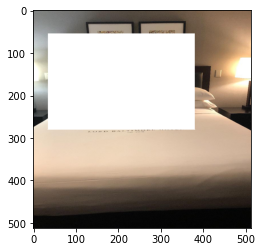

In [16]:
plt.imshow(masked_img)

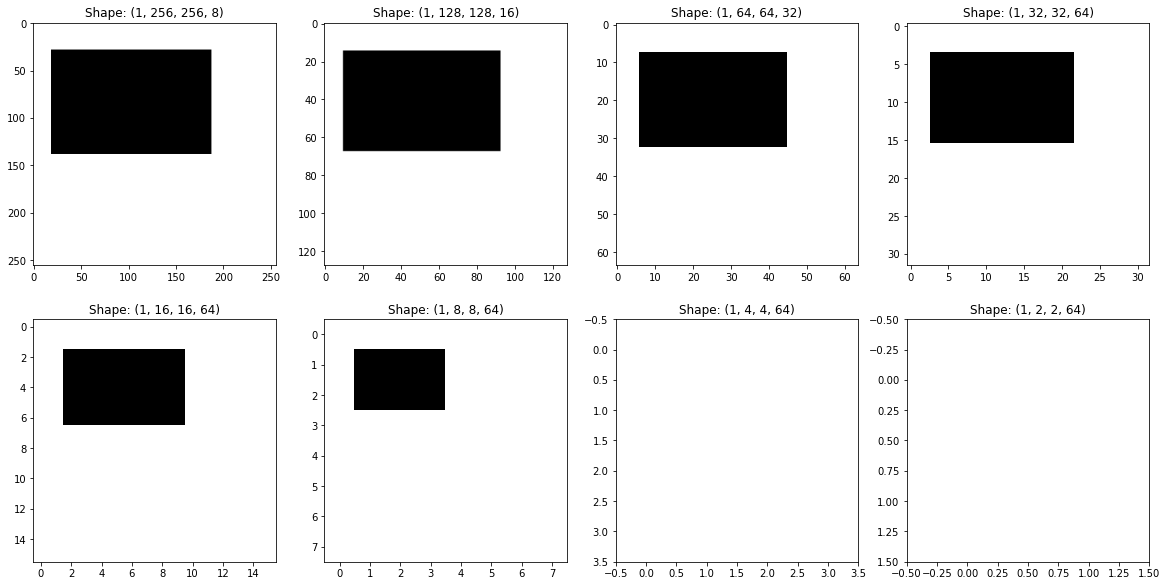

In [17]:
_, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0][0].imshow(o1[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][1].imshow(o2[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][2].imshow(o3[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][3].imshow(o4[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][0].imshow(o5[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][1].imshow(o6[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][2].imshow(o7[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][3].imshow(o8[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][0].set_title(f"Shape: {o1.shape}")
axes[0][1].set_title(f"Shape: {o2.shape}")
axes[0][2].set_title(f"Shape: {o3.shape}")
axes[0][3].set_title(f"Shape: {o4.shape}")
axes[1][0].set_title(f"Shape: {o5.shape}")
axes[1][1].set_title(f"Shape: {o6.shape}")
axes[1][2].set_title(f"Shape: {o7.shape}")
axes[1][3].set_title(f"Shape: {o8.shape}")
plt.show()

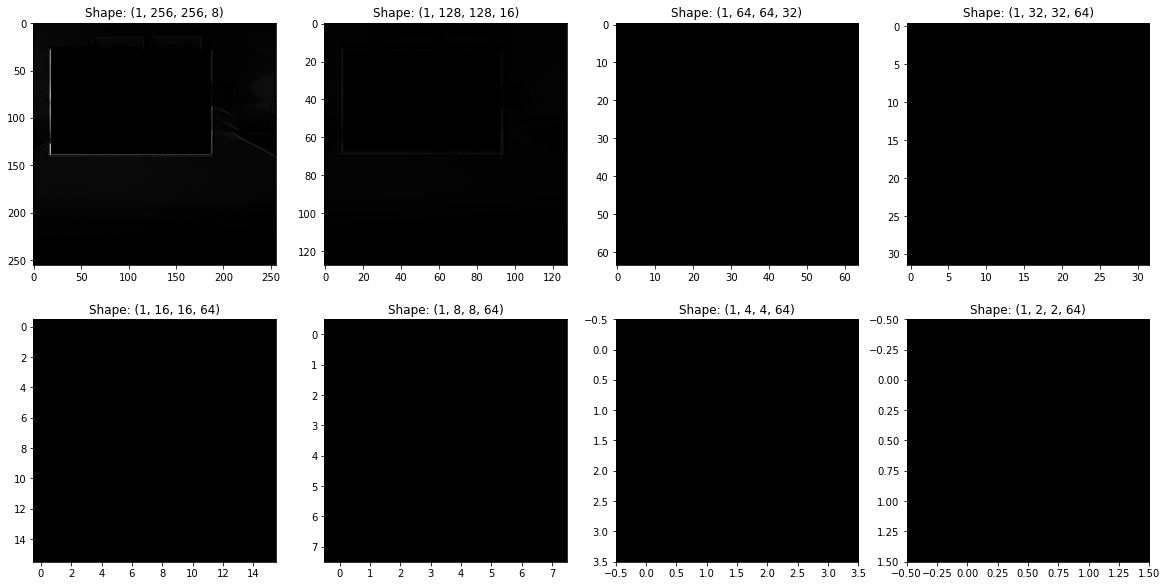

In [18]:
_, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0][0].imshow(o_img1[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][1].imshow(o_img2[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][2].imshow(o_img3[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][3].imshow(o_img4[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][0].imshow(o_img5[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][1].imshow(o_img6[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][2].imshow(o_img7[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][3].imshow(o_img[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][0].set_title(f"Shape: {o_img1.shape}")
axes[0][1].set_title(f"Shape: {o_img2.shape}")
axes[0][2].set_title(f"Shape: {o_img3.shape}")
axes[0][3].set_title(f"Shape: {o_img4.shape}")
axes[1][0].set_title(f"Shape: {o_img5.shape}")
axes[1][1].set_title(f"Shape: {o_img6.shape}")
axes[1][2].set_title(f"Shape: {o_img7.shape}")
axes[1][3].set_title(f"Shape: {o_img.shape}")
plt.show()

# implmenation model

In [14]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from libs.util import MaskGenerator
from libs.data_loaders import DataGenerator
from libs.unet_model import InpaintingUnet

# Settings
BATCH_SIZE = 1

In [3]:
#model = InpaintingUnet(conv_layer='pconv')

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Lambda
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import backend as K
from libs.pconv_layer import PConv2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback

In [16]:
def build_pconv_unet(train_bn=True):      

        # INPUTS
        inputs_img = Input((512, 512, 3), name='inputs_img')
        inputs_mask = Input((512, 512, 3), name='inputs_mask')
        
        # ENCODER
        def encoder_layer(img_in, mask_in, filters, kernel_size, bn=True):
            conv, mask = PConv2D(filters, kernel_size, strides=2, padding='same')([img_in, mask_in])
            if bn:
                conv = BatchNormalization(name='EncBN'+str(encoder_layer.counter))(conv, training=train_bn)
            conv = Activation('relu')(conv)
            encoder_layer.counter += 1
            return conv, mask
        encoder_layer.counter = 0
        
        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 64, 7, bn=False)
        e_conv2, e_mask2 = encoder_layer(e_conv1, e_mask1, 128, 5)
        e_conv3, e_mask3 = encoder_layer(e_conv2, e_mask2, 256, 5)
        e_conv4, e_mask4 = encoder_layer(e_conv3, e_mask3, 512, 3)
        e_conv5, e_mask5 = encoder_layer(e_conv4, e_mask4, 512, 3)
        e_conv6, e_mask6 = encoder_layer(e_conv5, e_mask5, 512, 3)
        e_conv7, e_mask7 = encoder_layer(e_conv6, e_mask6, 512, 3)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 512, 3)
        
        # DECODER
        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size, bn=True):
            up_img = UpSampling2D(size=(2,2))(img_in)
            up_mask = UpSampling2D(size=(2,2))(mask_in)
            concat_img = Concatenate(axis=3)([e_conv,up_img])
            concat_mask = Concatenate(axis=3)([e_mask,up_mask])
            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])
            if bn:
                conv = BatchNormalization()(conv)
            conv = LeakyReLU(alpha=0.2)(conv)
            return conv, mask
            
        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 512, 3)
        d_conv10, d_mask10 = decoder_layer(d_conv9, d_mask9, e_conv6, e_mask6, 512, 3)
        d_conv11, d_mask11 = decoder_layer(d_conv10, d_mask10, e_conv5, e_mask5, 512, 3)
        d_conv12, d_mask12 = decoder_layer(d_conv11, d_mask11, e_conv4, e_mask4, 512, 3)
        d_conv13, d_mask13 = decoder_layer(d_conv12, d_mask12, e_conv3, e_mask3, 256, 3)
        d_conv14, d_mask14 = decoder_layer(d_conv13, d_mask13, e_conv2, e_mask2, 128, 3)
        d_conv15, d_mask15 = decoder_layer(d_conv14, d_mask14, e_conv1, e_mask1, 64, 3)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask, 3, 3, bn=False)
        outputs = Conv2D(3, 1, activation = 'sigmoid', name='outputs_img')(d_conv16)
        
        # Setup the model inputs / outputs
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        return model, inputs_mask 

In [17]:
model, inputs_mask = build_pconv_unet()


2022-05-23 18:38:08.327372: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-23 18:38:08.329545: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [18]:
model.load_weights('pconv_imagenet.h5',by_name=False)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
p_conv2d (PConv2D)              [(None, 256, 256, 64 9472        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           p_conv2d[0][0]               

In [20]:
def PSNR(y_true, y_pred):
        """
        PSNR is Peek Signal to Noise Ratio, see https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
        The equation is:
        PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)
        
        Our input is scaled with be within the range -2.11 to 2.64 (imagenet value scaling). We use the difference between these
        two values (4.75) as MAX_I        
        """        
        #return 20 * K.log(4.75) / K.log(10.0) - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0) 
        return - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0) 

In [43]:
def loss_total(mask):
        """
        Creates a loss function which sums all the loss components 
        and multiplies by their weights. See paper eq. 7.
        """
        def loss(y_true, y_pred):

            # Compute predicted image with non-hole pixels set to ground truth
            y_comp = mask * y_true + (1-mask) * y_pred

            # Compute the vgg features. 
#             if self.vgg_device:
#                 with tf.device(self.vgg_device):
#                     vgg_out = self.vgg(y_pred)
#                     vgg_gt = self.vgg(y_true)
#                     vgg_comp = self.vgg(y_comp)
#             else:
#             vgg_out = vgg(y_pred)
#             vgg_gt = vgg(y_true)
#             vgg_comp = vgg(y_comp)
            
            # Compute loss components
            l1 = loss_valid(mask, y_true, y_pred)
            l2 = loss_hole(mask, y_true, y_pred)
            #l3 = loss_perceptual(vgg_out, vgg_gt, vgg_comp)
            #l4 = loss_style(vgg_out, vgg_gt)
            #l5 = loss_style(vgg_comp, vgg_gt)
            #l6 = loss_tv(mask, y_comp)

            # Return loss function
            #return l1 + 6*l2 
            return l1 + 6*l2
        return loss 

In [44]:
def loss_hole(mask, y_true, y_pred):
        """Pixel L1 loss within the hole / mask"""
        return l1((1-mask) * y_true, (1-mask) * y_pred)
    
def loss_valid(mask, y_true, y_pred):
    """Pixel L1 loss outside the hole / mask"""
    return l1(mask * y_true, mask * y_pred)

def loss_tv( mask, y_comp):
        """Total variation loss, used for smoothing the hole region, see. eq. 6"""

        # Create dilated hole region using a 3x3 kernel of all 1s.
        kernel = K.ones(shape=(3, 3, mask.shape[3], mask.shape[3]))
        dilated_mask = K.conv2d(1-mask, kernel, data_format='channels_last', padding='same')

        # Cast values to be [0., 1.], and compute dilated hole region of y_comp
        dilated_mask = K.cast(K.greater(dilated_mask, 0), 'float32')
        P = dilated_mask * y_comp

        # Calculate total variation loss
        a = l1(P[:,1:,:,:], P[:,:-1,:,:])
        b = l1(P[:,:,1:,:], P[:,:,:-1,:])        
        return a+b
    
def loss_perceptual(vgg_out, vgg_gt, vgg_comp): 
        """Perceptual loss based on VGG16, see. eq. 3 in paper"""       
        loss = 0
        for o, c, g in zip(vgg_out, vgg_comp, vgg_gt):
            loss += l1(o, g) + l1(c, g)
        return loss
        
def loss_style(output, vgg_gt):
        """Style loss based on output/computation, used for both eq. 4 & 5 in paper"""
        loss = 0
        for o, g in zip(output, vgg_gt):
            loss += l1(gram_matrix(o), gram_matrix(g))
        return loss
 

In [45]:
def l1(y_true, y_pred):
        """Calculate the L1 loss used in all loss calculations"""
        if K.ndim(y_true) == 4:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2,3])
        elif K.ndim(y_true) == 3:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2])
        else:
            raise NotImplementedError("Calculating L1 loss on 1D tensors? should not occur for this network")



In [46]:
def gram_matrix(x, norm_by_channels=False):
        """Calculate gram matrix used in style loss"""
        
        # Assertions on input
        assert K.ndim(x) == 4, 'Input tensor should be a 4d (B, H, W, C) tensor'
        assert K.image_data_format() == 'channels_last', "Please use channels-last format"        
        
        # Permute channels and get resulting shape
        x = K.permute_dimensions(x, (0, 3, 1, 2))
        shape = K.shape(x)
        B, C, H, W = shape[0], shape[1], shape[2], shape[3]
        
        # Reshape x and do batch dot product
        features = K.reshape(x, K.stack([B, C, H*W]))
        gram = K.batch_dot(features, features, axes=2)
        
        # Normalize with channels, height and width
        gram = gram /  K.cast(C * H * W, x.dtype)
        
        return gram

In [25]:
from tensorflow.keras.applications import VGG16

In [33]:
def build_vgg(weights="imagenet"):
        """
        Load pre-trained VGG16 from keras applications
        Extract features to be used in loss function from last conv layer, see architecture at:
        https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py
        """        
        
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        mean = 0.485
        std = 0.229
        
        vgg_layers = [3, 6, 10]
        # Input image to extract features from
        img = Input(shape=(512, 512, 3))

        # Mean center and rescale by variance as in PyTorch
        processed = Lambda(lambda x: (x-mean) / std)(img)
        
        # If inference only, just return empty model        
#         if self.inference_only:
#             model = Model(inputs=img, outputs=[img for _ in range(len(self.vgg_layers))])
#             model.trainable = False
#             model.compile(loss='mse', optimizer='adam')
#             return model
                
        # Get the vgg network from Keras applications
        if weights in ['imagenet']:
            vgg = VGG16(weights=weights, include_top=False)
        else:
            vgg = VGG16(weights='imagenet', include_top=False)
            vgg.load_weights(weights, by_name=True)

        # Output the first three pooling layers
        vgg.outputs = [vgg.layers[i].output for i in vgg_layers]        
        
        # Create model and compile
        model = Model(inputs=img, outputs=vgg(processed))
        model.trainable = False
        model.compile(loss='mse', optimizer='adam')

        return model



In [39]:
#vgg = build_vgg()

In [63]:
#tf.config.experimental_run_functions_eagerly(False)

In [64]:
def compile_pconv_unet(model, inputs_mask, lr=0.0002):
        model.compile(
            optimizer = Adam(lr=lr),
            loss=loss_total(inputs_mask),
            metrics=[PSNR],
            experimental_run_tf_function=False
        )

In [65]:
compile_pconv_unet(model, inputs_mask)

In [68]:
img_list= np.array([img]).repeat(20,axis=0).reshape(-1,512,512,3)
mask_list= np.array([mask_img]).repeat(20,axis=0).reshape(-1,512,512,3)
masked_list= np.array([masked_img]).repeat(20,axis=0).reshape(-1,512,512,3)

In [50]:
img_list.shape

(2, 512, 512, 3)

In [52]:
img_list.shape

(300, 512, 512, 3)

In [53]:
#generator = [masked_list,mask_list],img_list

In [66]:
def plot_sample_data(masked, mask, ori, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title(middle_title)
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()     

Train on 20 samples
Epoch 1/5


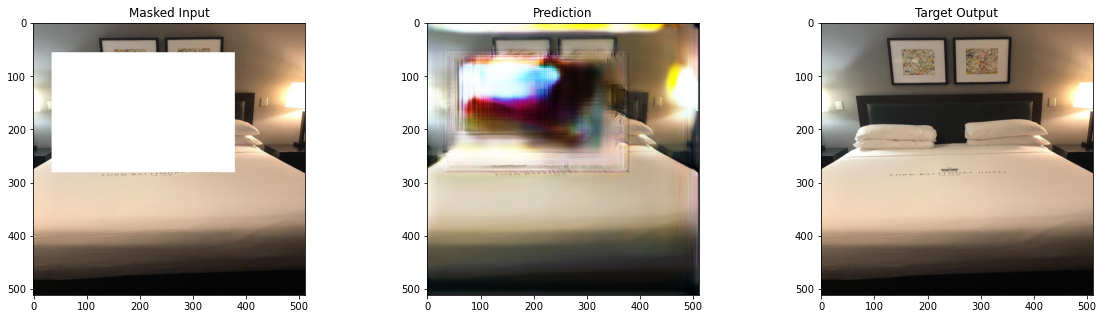

20/20 [==============================] - 176s 9s/sample - loss: 0.3024 - PSNR: 18.0923
Epoch 2/5


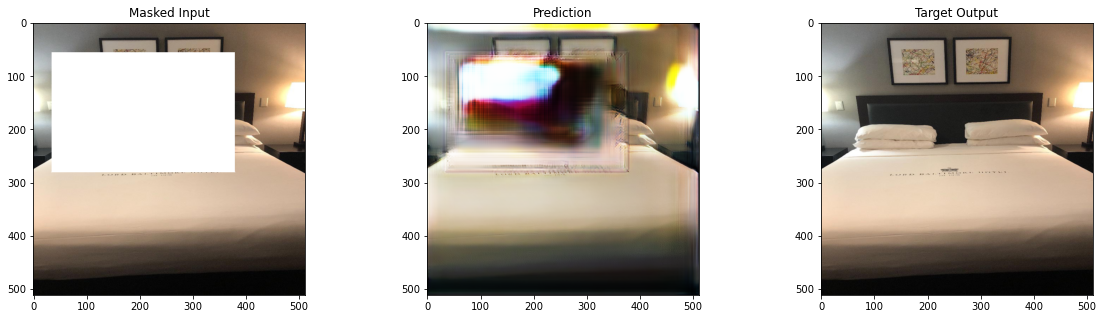

20/20 [==============================] - 183s 9s/sample - loss: 0.2575 - PSNR: 19.1781
Epoch 3/5


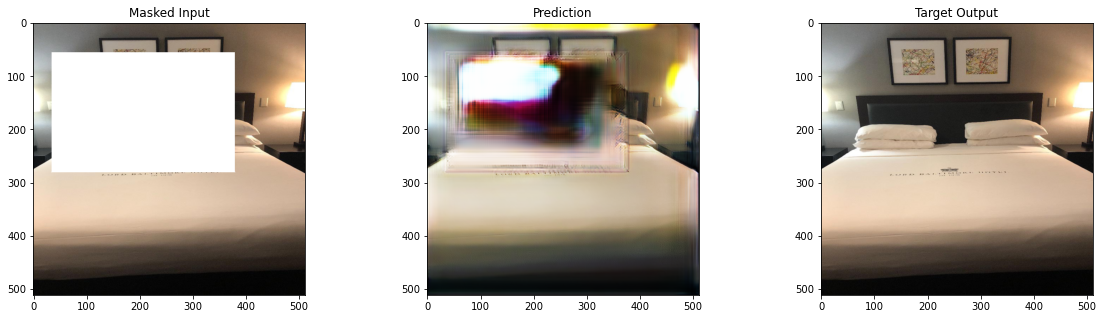

20/20 [==============================] - 168s 8s/sample - loss: 0.2417 - PSNR: 19.5301
Epoch 4/5


In [ ]:
model.fit(x= [img_list,mask_list],y =img_list, batch_size=len(img_list), epochs=5,callbacks=[ LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(img,0), 
                        np.expand_dims(mask_img,0)
                    ]
                )[0]
                , 
                img,
                middle_title='Prediction'
            )
        )])

In [54]:
BATCH_SIZE = 8

In [55]:
#FOLDER = './data/logs/single_image_test'

model.fit(
    #x= [img_list,mask_list],y =img_list, 
    generator[0],
    #steps_per_epoch=1,
    epochs=1,
    callbacks=[
#         TensorBoard(
#             log_dir=FOLDER,
#             write_graph=False,
#             profile_batch=0
#         ),
#         ModelCheckpoint(
#             os.path.join(FOLDER, 'weights.Epoch-{epoch:02d}.PSNR-{PSNR:.2f}'),
#             monitor='PSNR', mode='max',
#             save_best_only=True, 
#             save_weights_only=True
#         ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask_img,0)
                    ]
                )[0], 
                img,
                middle_title='Prediction'
            )
        )
    ],
)

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 300 samples

In [45]:
BATCH_SIZE

2

In [36]:
model.fit(x= [masked_img,mask_list],y =img_list, batch_size=len(img_list), epochs=1,callbacks=[ LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(img,0), 
                        np.expand_dims(mask_img,0)
                    ]
                )[0]
                , 
                img,
                middle_title='Prediction'
            )
        )])

TypeError: fit() missing 1 required positional argument: 'generator'